In [7]:
from utils_others import *

In [8]:
api_key=""
# 放入gemini api (我的api余额已经快用光光了.....捂脸)

In [9]:
# 模型设定
gemini_hypers = {
    'temp': 0.2,  # temp 在0.2 or 0.4是比较好的，不过这个寻优只是通过MAPE,R^2找到，因为gemini没办法得到输出token的log-p，无法调用validation-likelihood function
    # 话又说回来, 似乎validation-likelihood function也不一定使得模型表现更好......
    'alpha': 0.95,
    'beta': 0.3,
    'basic': [False],
    'settings': [SerializerSettings(base=10, prec=3, signed=True,half_bin_correction=True)],
    # prec可能=3
}

model_hypers = {
    'gemini-1.0-pro': {'model': 'gemini-1.0-pro', **gemini_hypers},
    # 'gemini-pro': {'model': 'gemini-pro', **gemini_hypers}
}

model_predict_fns = {
    'gemini-1.0-pro': get_llmtime_predictions_data,  # 此处假定用gpt系列的encoding方式来进行预测
    # 'gemini-pro': get_llmtime_predictions_data
}


In [10]:
datasets = get_datasets()  
datasets_tmp = get_memorization_datasets()
datasets.update(datasets_tmp)

D:\Desktop\Works_left_over\0-已完成 (形式上)\1-Time-LLM\2-llmtime-main\llmtime-main\data1\small_context.py:115: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  series = pd.read_csv(f, index_col=0, parse_dates=True).values.reshape(-1)


In [11]:
# 一些参数设置和数据集选择
dataset_name = 'WineDataset'  # 免费版gemini跑IstanbulTraffic数据集总是会报错(安全不合格), 其他数据集偶尔报错, 目前不知道原因
train, test = datasets[dataset_name]

num_samples = 10  # 跑多少次


In [12]:
n = 1  # 表示减少的周期长度数
period = 12  # WineDataset 来做预测, 12 是其真实 (提前给定的) 周期
all_rounds = int(len(train)/period)

output_ = []  # 记录是否有该现象

# 按照周期的倍数, 从训练集开头减少序列长度
for index in range(0, all_rounds):  
    print('Round:', index)
    train_tmp = copy.deepcopy(train)
    test_tmp = copy.deepcopy(test)
    train_tmp = train_tmp.iloc[(index*period):]
    
    if index > 0:  # 免费版 gemini 在短时间内大量调用会报错, 时间比较多时可以考虑把 sleep 时间延长
        time.sleep(60)
    out_gemini_pro, out_gemini_pro_number = prediction_gemini(model_predict_fns, train, test, model_hypers, num_samples=num_samples, whether_blanket=False, dataset_name=dataset_name, genai_key=api_key)
    mse_mean, mae_mean, mape_mean, r2_mean = metrics_used(test, dataset_name, original_pred = out_gemini_pro_number, num_samples=num_samples)

    output_.append({'index': index, 'mse': mse_mean, 'mae': mae_mean, 'mape': mape_mean, 'r2': r2_mean})

Round: 0
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.2, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'WineDataset'}) 
 with NLL inf



  0%|          | 0/1 [00:00<?, ?it/s]

Index: 0
Index: 1


KeyboardInterrupt: 

In [13]:
mape_list = []
r2_list = []
mae_list = []
for dict in output_:
    mape_list.append(dict['mape'])
    r2_list.append(dict['r2'])
    mae_list.append(dict['mae'])

def find_minimum_index(lst):
    min_value = min(lst)
    min_index = lst.index(min_value)
    return min_index

def find_maximum_index(lst):
    max_value = max(lst)
    max_index = lst.index(max_value)
    return max_index

argmin_mape = find_minimum_index(mape_list)
argmax_r2 = find_maximum_index(r2_list)

print(argmin_mape, argmax_r2)

ValueError: min() arg is an empty sequence

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


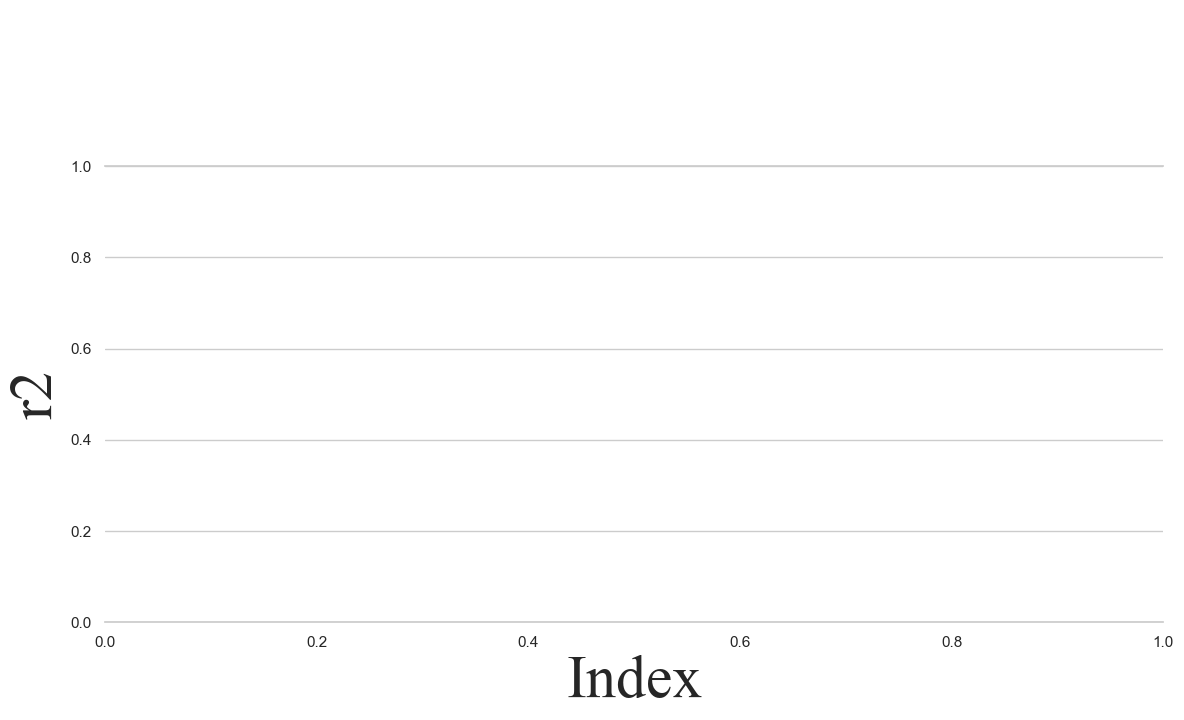

In [14]:
fig_length(metric=r2_list, metric_name='r2', dataset_name='WineDataset')